In [121]:
import os
import zipfile
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt
import cv2 


from glob import glob
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from typing import Optional
from kaggle.api.kaggle_api_extended import KaggleApi
from PIL import Image

In [2]:
data_path = os.path.join(os.getcwd(), 'data')

print(data_path)

kaggle.api.authenticate()
kaggle.api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', path=data_path, unzip = True)

/mnt/c/Users/akaas/Documents/SM_project/project-folder/data


In [122]:
data = pd.read_csv('data/hmnist_28_28_RGB.csv')

In [123]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


**Understanding the data**

The dataset includes 10015 images that are 28 x 28 pixels = 784 pixels As they are RGB images and not gray scale they must be multipled by 3 (R, G, B). In total, there are 2352 pixels.

In [124]:
X = data.drop(columns='label')/255
Y = data['label']

num_rows, num_cols = 28, 28
num_classes = len(set(Y))

In [125]:
X = np.array(X)
X = X.reshape(X.shape[0], num_rows, num_cols, 3)

In [126]:
Y = np.eye(num_classes)[np.array(Y.astype(int)).reshape(-1)]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#Split the dataset into 80% training and 20% test

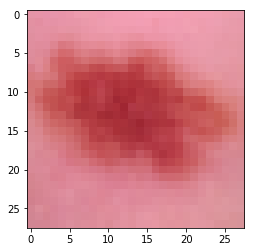

In [128]:
plt.imshow(X_train[0].reshape(28,28,3))

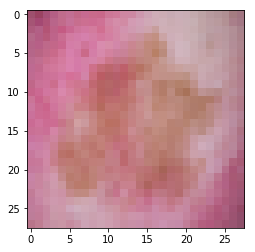

In [129]:
plt.imshow(X_test[0].reshape(28,28,3))

In [130]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_rows, num_cols, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout_32 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)             

**Changes to the model**
Early stopping
Changing the drop %
Including a train, test split (+ validation split within training)

In [132]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [133]:
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.10, callbacks=[early_stopping])
#10% drop 30% drop 50% drop

Train on 7210 samples, validate on 802 samples
Epoch 1/30
7210/7210 [==============================] - 6s 882us/step - loss: 1.0702 - accuracy: 0.6637 - val_loss: 0.8970 - val_accuracy: 0.6958
Epoch 2/30
7210/7210 [==============================] - 6s 782us/step - loss: 0.9476 - accuracy: 0.6675 - val_loss: 0.8689 - val_accuracy: 0.6958
Epoch 3/30
7210/7210 [==============================] - 6s 821us/step - loss: 0.9041 - accuracy: 0.6739 - val_loss: 0.7896 - val_accuracy: 0.7007
Epoch 4/30
7210/7210 [==============================] - 6s 772us/step - loss: 0.8648 - accuracy: 0.6807 - val_loss: 0.7654 - val_accuracy: 0.7107
Epoch 5/30
7210/7210 [==============================] - 5s 758us/step - loss: 0.8424 - accuracy: 0.6875 - val_loss: 0.7288 - val_accuracy: 0.7307
Epoch 6/30
7210/7210 [==============================] - 5s 727us/step - loss: 0.8137 - accuracy: 0.6945 - val_loss: 0.7334 - val_accuracy: 0.7294
Epoch 7/30
7210/7210 [==============================] - 5s 713us/step - loss:

In [135]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 0s 163us/step
Test: accuracy = 0.702446  ;  loss = 0.788722


In [138]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_rows, num_cols, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout_41 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)             

In [139]:
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.10, callbacks=[early_stopping])
#10% drop 50% drop 50% drop

Train on 7210 samples, validate on 802 samples
Epoch 1/30
7210/7210 [==============================] - 5s 747us/step - loss: 1.0627 - accuracy: 0.6612 - val_loss: 0.9465 - val_accuracy: 0.6858
Epoch 2/30
7210/7210 [==============================] - 5s 714us/step - loss: 0.9613 - accuracy: 0.6702 - val_loss: 0.8181 - val_accuracy: 0.6995
Epoch 3/30
7210/7210 [==============================] - 5s 729us/step - loss: 0.9072 - accuracy: 0.6750 - val_loss: 0.8004 - val_accuracy: 0.7020
Epoch 4/30
7210/7210 [==============================] - 5s 719us/step - loss: 0.8827 - accuracy: 0.6857 - val_loss: 0.7794 - val_accuracy: 0.7107
Epoch 5/30
7210/7210 [==============================] - 5s 692us/step - loss: 0.8595 - accuracy: 0.6822 - val_loss: 0.7521 - val_accuracy: 0.7182
Epoch 6/30
7210/7210 [==============================] - 5s 707us/step - loss: 0.8377 - accuracy: 0.6915 - val_loss: 0.7294 - val_accuracy: 0.7357
Epoch 7/30
7210/7210 [==============================] - 5s 708us/step - loss:

In [140]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 0s 169us/step
Test: accuracy = 0.713430  ;  loss = 0.744871


In [141]:
base_skin_dir = os.path.join('..', 'project-folder/data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [142]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data.sample(3)
#Match the images from the folders and include them in the csv file

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5922,HAM_0004509,ISIC_0028028,nv,follow_up,45.0,male,trunk,../project-folder/data/HAM10000_images_part_1/...,Melanocytic nevi,4
3028,HAM_0007193,ISIC_0025398,nv,follow_up,45.0,male,trunk,../project-folder/data/HAM10000_images_part_1/...,Melanocytic nevi,4
5837,HAM_0002573,ISIC_0030018,nv,follow_up,45.0,male,lower extremity,../project-folder/data/HAM10000_images_part_2/...,Melanocytic nevi,4


In [143]:
skin_data.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [144]:
skin_data['age'].fillna((skin_data['age'].mean()), inplace=True)
#Replace null age with mean age

In [145]:
skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((37,28))))
#Based on the aspect ration 37 x 28 is clearer than 28 x 28 so testing if this improves accuracy

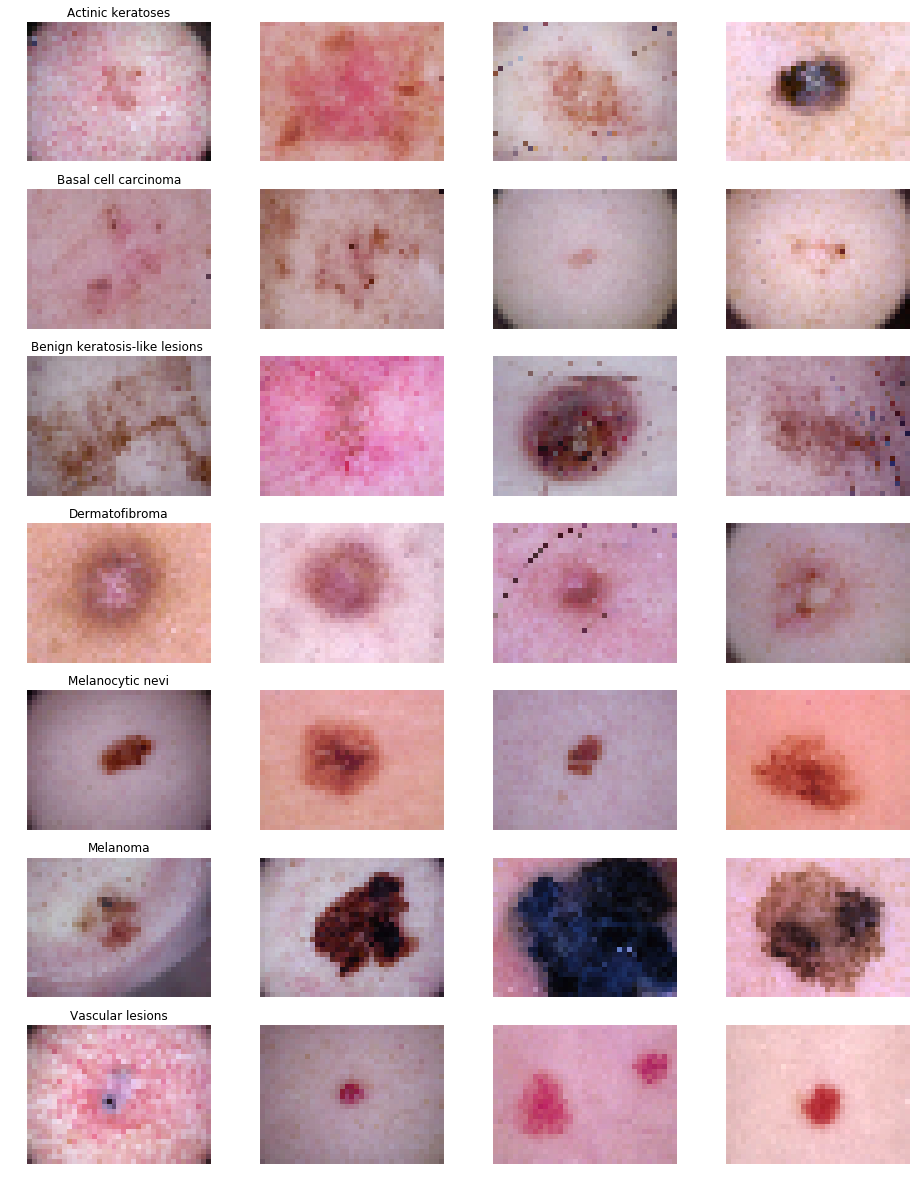

In [147]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=6542).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [148]:
# Checking the image size distribution
skin_data['image'].map(lambda x: x.shape).value_counts()
#Selected 28 x 37 to keep the aspect ratio and see if there is an improvement

(28, 37, 3)    10015
Name: image, dtype: int64

In [149]:
features = skin_data.drop(columns=['cell_type_idx'],axis=1)
label = skin_data['cell_type_idx']

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.20,random_state=6542)

In [150]:
x_train = np.asarray(x_train['image'].tolist())

In [151]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

In [152]:
x_test = np.asarray(x_test['image'].tolist())

In [153]:
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

In [154]:
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
#New approach to normalizing

In [155]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [156]:
input_shape = (28, 37, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 28, 37, 32)        896       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 18, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 14, 18, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 18, 64)        18496     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 9, 64)        

In [157]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [158]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [159]:
model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.10, callbacks=[learning_rate_reduction])

Train on 7210 samples, validate on 802 samples
Epoch 1/30
7210/7210 [==============================] - 20s 3ms/step - loss: 0.9847 - accuracy: 0.6641 - val_loss: 0.8721 - val_accuracy: 0.6683
Epoch 2/30
7210/7210 [==============================] - 18s 2ms/step - loss: 0.8620 - accuracy: 0.6809 - val_loss: 0.8549 - val_accuracy: 0.6883
Epoch 3/30
7210/7210 [==============================] - 17s 2ms/step - loss: 0.8290 - accuracy: 0.7003 - val_loss: 0.8880 - val_accuracy: 0.6808
Epoch 4/30
7210/7210 [==============================] - 17s 2ms/step - loss: 0.7980 - accuracy: 0.7101 - val_loss: 0.8148 - val_accuracy: 0.6970
Epoch 5/30
7210/7210 [==============================] - 17s 2ms/step - loss: 0.7657 - accuracy: 0.7186 - val_loss: 0.7882 - val_accuracy: 0.7107
Epoch 6/30
7210/7210 [==============================] - 18s 2ms/step - loss: 0.7469 - accuracy: 0.7309 - val_loss: 0.7700 - val_accuracy: 0.7244
Epoch 7/30
7210/7210 [==============================] - 19s 3ms/step - loss: 0.7238

In [160]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 1s 483us/step
Test: accuracy = 0.774338  ;  loss = 0.754222
